# Using a pretrained model - ResNet18

**Note:** We highly recommend running this notebook on a GPU. 

## 0. Initialization

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
import os

os.chdir("..")
import requests
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from src.utils import seed_everything
from torchvision.models import resnet18, ResNet18_Weights
from src.loading import load_data
from src.train import train
from IPython.display import clear_output

In [4]:
# Set the seeds
seed_everything()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



---

<a name='s1'></a>
## 1. Downloading the dataset

Fetching the dataset should take around 4-5 minutes.

Unzipping the file, and placing in in data/ folder, this takes 20s.

In [5]:
# if folder 'data/' is does not exist, download the data
if not os.path.exists("data/"):
    # Dropbox URL
    dropbox_url = "https://www.dropbox.com/scl/fi/sa14unf8s47e9ym125zgo/data.zip?rlkey=198bg0cmbmmrcjkfufy9064wm&dl=1"

    # File path where the .zip file will be saved
    file_path = "data.zip"

    response = requests.get(dropbox_url)

    if response.status_code == 200:
        with open(file_path, "wb") as file:
            file.write(response.content)
        message = "Download successful. The file has been saved as 'data.zip'."
    else:
        message = "Failed to download the file. Error code: " + str(
            response.status_code
        )

    print(message)

    # Path to the downloaded .zip file
    zip_file_path = "data.zip"

    # Directory to extract the contents of the zip file
    extraction_path = ""

    # Unzipping the file
    with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
        zip_ref.extractall(extraction_path)

    extraction_message = (
        f"The contents of the zip file have been extracted to: {extraction_path}"
    )

    print(extraction_message)

## 2. Data

Load the data with improved preprocessing. Set the batch size according to your machine, here we tried to set it as high as possible, as long as the GPU/CPU has enough memory.

In [6]:
# load the .jpeg files in the data folder
PATH_IMAGES = "data/images_keep_ar"
PATH_LABELS = "data/labels/trainLabels.csv"
batch_size = 8  # default 8
img_size = (300, 300)  # default size 120/120
num_epochs = 20

Load train and validation, 90-10 ratio. 

In [7]:
train_loader, validation_loader = load_data(
    PATH_LABELS, PATH_IMAGES, img_size, batch_size
)

Number of train samples:31964
Number of validation samples:3162


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([8, 3, 300, 300])
torch.Size([8])


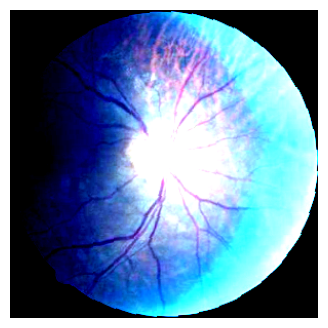

In [8]:
# Visualize a single image
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    plt.figure(figsize=(4, 4))
    plt.axis("off")
    plt.imshow(np.transpose(images[0], (1, 2, 0)))
    plt.show()
    break

## 3. Model

Here we are using a pretrained ResNet18 model. It has been trained on the ImageNet dataset, which contains 1.2 million images and 1000 classes. ResNet18 is a 72-layer architecture with 18 deep layers. 
We will train the last few layers of the network. The first layers are already trained to detect low-level features such as edges and corners. The last layers are trained to detect high-level features such as roads, people, since its pretraiend on ImageNet.


In [ ]:
# Initialize model with the best available weights
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)

There are 4 major layer blocks in the ResNet18 architecture. We will unfreeze only the last one, together with the classifier.

In [9]:
parameters_to_train = []

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False
    parameters_to_train.append(param)

# Replace the last layer
model.fc = nn.Linear(512, 5)

# Unfreeze the last layer
for param in model.fc.parameters():
    param.requires_grad = True
    parameters_to_train.append(param)

# Unfreeze layer 4
for param in model.layer4.parameters():
    param.requires_grad = True
    parameters_to_train.append(param)

In [10]:
optimizer = optim.Adam(parameters_to_train, lr=3e-5)
criterion = nn.CrossEntropyLoss()
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Optional. If you want to fine tune this model, we advise you to do it in steps. Load the last checkpoint to continue with training. 

In [11]:
# # load the previous model, if there is one
# MODEL = "results/models/resnet_baseline.pt"
# checkpoint = torch.load(MODEL)
# model.load_state_dict(checkpoint)

### 3.1 Model training and evaluation

In [ ]:
train(
    model,
    train_loader,
    validation_loader,
    criterion,
    optimizer,
    device,
    model_name="results/models/resnet_baseline.pt",
    num_epochs=num_epochs,
)